# 身體姿勢估計
此處我們使用網上以open pose提取特徵後，基於Mobilenet數據集訓練得到的DNN模型(graph_opt.pb)
參考資料:
- https://github.com/CMU-Perceptual-Computing-Lab/openpose
- https://github.com/quanhua92/human-pose-estimation-opencv
- https://github.com/opencv/opencv/blob/master/samples/dnn/openpose.py

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt


BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

image_width=368
image_height=368
# 门槛值
threshold=0.2

<div><img src="./resources/image.jpg" width="500"/></div>

In [2]:
# 將圖片讀入
img = cv.imread('./resources/image.jpg',cv.IMREAD_UNCHANGED)

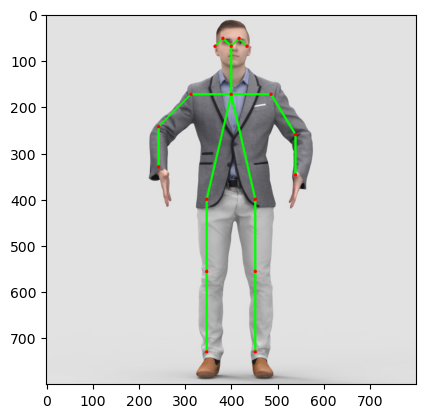

In [3]:
# 載入預訓練好的模型
net = cv.dnn.readNetFromTensorflow("graph_opt.pb")

photo_height=img.shape[0]
photo_width=img.shape[1]
net.setInput(cv.dnn.blobFromImage(img, 1.0, (image_width, image_height), (127.5, 127.5, 127.5), swapRB=True, crop=False))

out = net.forward()
out = out[:, :19, :, :] 

assert(len(BODY_PARTS) == out.shape[1])

points = []
for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponging body's part.
    heatMap = out[0, i, :, :]

        # Originally, we try to find all the local maximums. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way.
    _, conf, _, point = cv.minMaxLoc(heatMap)
    x = (photo_width * point[0]) / out.shape[3]
    y = (photo_height * point[1]) / out.shape[2]
    # Add a point if it's confidence is higher than threshold.
    points.append((int(x), int(y)) if conf > threshold else None)


for pair in POSE_PAIRS:
    partFrom = pair[0]
    partTo = pair[1]
    assert(partFrom in BODY_PARTS)
    assert(partTo in BODY_PARTS)

    idFrom = BODY_PARTS[partFrom]
    idTo = BODY_PARTS[partTo]

    if points[idFrom] and points[idTo]:
        cv.line(img, points[idFrom], points[idTo], (0, 255, 0), 3)
        cv.ellipse(img, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
        cv.ellipse(img, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

t, _ = net.getPerfProfile()

#cv.imshow("cool",img)
face_img = img.copy() #建立复本,避免影响原本的图像
face_img_RGB = cv.cvtColor(face_img, cv.COLOR_BGR2RGB) # OpenCV用BGR顺序,而matplotlib用RGB, 所以必须做一次转换 

plt.imshow(face_img_RGB)
plt.show()